In [1]:
from google.colab import drive
import os
import warnings
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Chemin vers le dossier dataset dans Google Drive
data_dir = '/content/drive/MyDrive/pfa/pre_dataset'

# Afficher la liste des fichiers dans le dossier dataset
files = os.listdir(data_dir)
print(files)

['training', 'Testing']


In [3]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from pandas import DataFrame
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, MaxPooling2D, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

In [4]:
# Chemin vers les dossiers d'entraînement et de test
train_dic = '/content/drive/MyDrive/pfa/pre_dataset/training'
test_dic = '/content/drive/MyDrive/pfa/pre_dataset/Testing'

# Définition des classes et des paramètres
CLASS_NAME = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
N_CLASS = len(CLASS_NAME)
LR = 0.01

# Chargement des données sans prétraitement supplémentaire
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dic,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=99
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dic,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=99
)

Found 5521 files belonging to 4 classes.
Found 1284 files belonging to 4 classes.


In [6]:
# Calculate the number of batches for splitting
n_test_batches = tf.data.experimental.cardinality(test_dataset).numpy()
n_val_batches = n_test_batches // 2

# Split the test dataset into validation and test datasets
validation_data = test_dataset.take(n_val_batches)
test_dataset = test_dataset.skip(n_val_batches)

In [7]:
# Function to count the number
def count_elements(dataset):
    return sum(1 for _ in dataset)

# Count the number of batches in each dataset
num_validation_batches = count_elements(validation_data)
num_test_batches = count_elements(test_dataset)

# Since each batch contains `BATCH_SIZE` images, multiply the number of batches by `BATCH_SIZE`
num_validation_images = num_validation_batches * BATCH_SIZE
num_test_images = num_test_batches * BATCH_SIZE

print(f'Number of images in validation_data: {num_validation_images}')
print(f'Number of images in test_dataset: {num_test_images}')

Number of images in validation_data: 640
Number of images in test_dataset: 656


In [8]:

# Création du modèle ResNet34
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding='valid'):
        super(CustomConv2D, self).__init__(name='custom_conv2d')
        self.conv = Conv2D(
            filters=n_filters,
            kernel_size=kernel_size,
            activation='relu',
            strides=n_strides,
            padding=padding
        )
        self.batch_norm = BatchNormalization()

    def call(self, x, training=True):
        x = self.conv(x)
        x = self.batch_norm(x, training=training)
        return x

class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides=1):
        super(ResidualBlock, self).__init__(name='res_block')
        self.dotted = (n_strides != 1)
        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding="same")
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding="same")
        self.activation = Activation('relu')
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

    def call(self, input, training):
        x = self.custom_conv_1(input, training=training)
        x = self.custom_conv_2(x, training=training)
        if self.dotted:
            x_add = self.custom_conv_3(input, training=training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, input])
        return self.activation(x_add)

In [9]:
from tensorflow.keras.layers import Layer, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf

# Définir CustomConv2D et ResidualBlock ici...

class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='resnet_34')
        self.conv_1 = CustomConv2D(64, 7, 2, padding='same')
        self.max_pool = MaxPooling2D(3, 2)
        self.conv_2_1 = ResidualBlock(64)
        self.dropout_1 = Dropout(0.5)  # Ajout de Dropout
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        self.conv_3_1 = ResidualBlock(128, 2)
        self.dropout_2 = Dropout(0.5)  # Ajout de Dropout
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)
        self.conv_4_1 = ResidualBlock(256, 2)
        self.dropout_3 = Dropout(0.5)  # Ajout de Dropout
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
        self.conv_5_1 = ResidualBlock(512, 2)
        self.dropout_4 = Dropout(0.5)  # Ajout de Dropout
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)
        self.global_pool = GlobalAveragePooling2D()
        self.fc_3 = Dense(N_CLASS, activation='softmax')

    def call(self, x, training=True):
        x = self.conv_1(x)
        x = self.max_pool(x)
        x = self.conv_2_1(x, training=training)
        x = self.dropout_1(x, training=training)  # Utilisation de Dropout
        x = self.conv_2_2(x, training=training)
        x = self.conv_2_3(x, training=training)
        x = self.conv_3_1(x, training=training)
        x = self.dropout_2(x, training=training)  # Utilisation de Dropout
        x = self.conv_3_2(x, training=training)
        x = self.conv_3_3(x, training=training)
        x = self.conv_3_4(x, training=training)
        x = self.conv_4_1(x, training=training)
        x = self.dropout_3(x, training=training)  # Utilisation de Dropout
        x = self.conv_4_2(x, training=training)
        x = self.conv_4_3(x, training=training)
        x = self.conv_4_4(x, training=training)
        x = self.conv_4_5(x, training=training)
        x = self.conv_4_6(x, training=training)
        x = self.conv_5_1(x, training=training)
        x = self.dropout_4(x, training=training)  # Utilisation de Dropout
        x = self.conv_5_2(x, training=training)
        x = self.conv_5_3(x, training=training)
        x = self.global_pool(x)
        return self.fc_3(x)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
# Création de l'instance du modèle
resnet_34 = ResNet34()

# Affichage d'un exemple de prédiction
resnet_34(tf.zeros([1, 224, 224, 3]), training=False)

# Résumé du modèle
resnet_34.summary()

# Compilation du modèle
loss_function = tf.keras.losses.CategoricalCrossentropy()
metric = [
    'accuracy',
    tf.keras.metrics.MeanAbsoluteError(name='MeanError'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]
resnet_34.compile(
    optimizer=Adam(learning_rate=LR),
    loss=loss_function,
    metrics=metric
)

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74

In [11]:
# Créer une instance de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte de validation
    patience=5,           # Nombre d'époques à attendre avant l'arrêt
    restore_best_weights=True  # Restaurer les meilleurs poids du modèle après l'arrêt
)

# Entraîner le modèle avec l'arrêt précoce
history = resnet_34.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_data,
    callbacks=[early_stopping]  # Utiliser l'arrêt précoce comme callback
)

Epoch 1/30
346/346 [==============================] - 2314s 6s/step - loss: 1.2656 - accuracy: 0.6225 - MeanError: 0.2300 - tp: 3038.0000 - fp: 1449.0000 - tn: 15114.0000 - fn: 2483.0000 - precision: 0.6771 - recall: 0.5503 - AUC: 0.8421 - val_loss: 3.5616 - val_accuracy: 0.5078 - val_MeanError: 0.2491 - val_tp: 321.0000 - val_fp: 313.0000 - val_tn: 1607.0000 - val_fn: 319.0000 - val_precision: 0.5063 - val_recall: 0.5016 - val_AUC: 0.7116
Epoch 2/30
346/346 [==============================] - 50s 144ms/step - loss: 0.7726 - accuracy: 0.7417 - MeanError: 0.1792 - tp: 3834.0000 - fp: 1148.0000 - tn: 15415.0000 - fn: 1687.0000 - precision: 0.7696 - recall: 0.6944 - AUC: 0.9162 - val_loss: 2.4424 - val_accuracy: 0.4219 - val_MeanError: 0.2858 - val_tp: 266.0000 - val_fp: 342.0000 - val_tn: 1578.0000 - val_fn: 374.0000 - val_precision: 0.4375 - val_recall: 0.4156 - val_AUC: 0.7006
Epoch 3/30
346/346 [==============================] - 49s 141ms/step - loss: 0.5444 - accuracy: 0.8149 - MeanEr

<Figure size 2000x800 with 0 Axes>

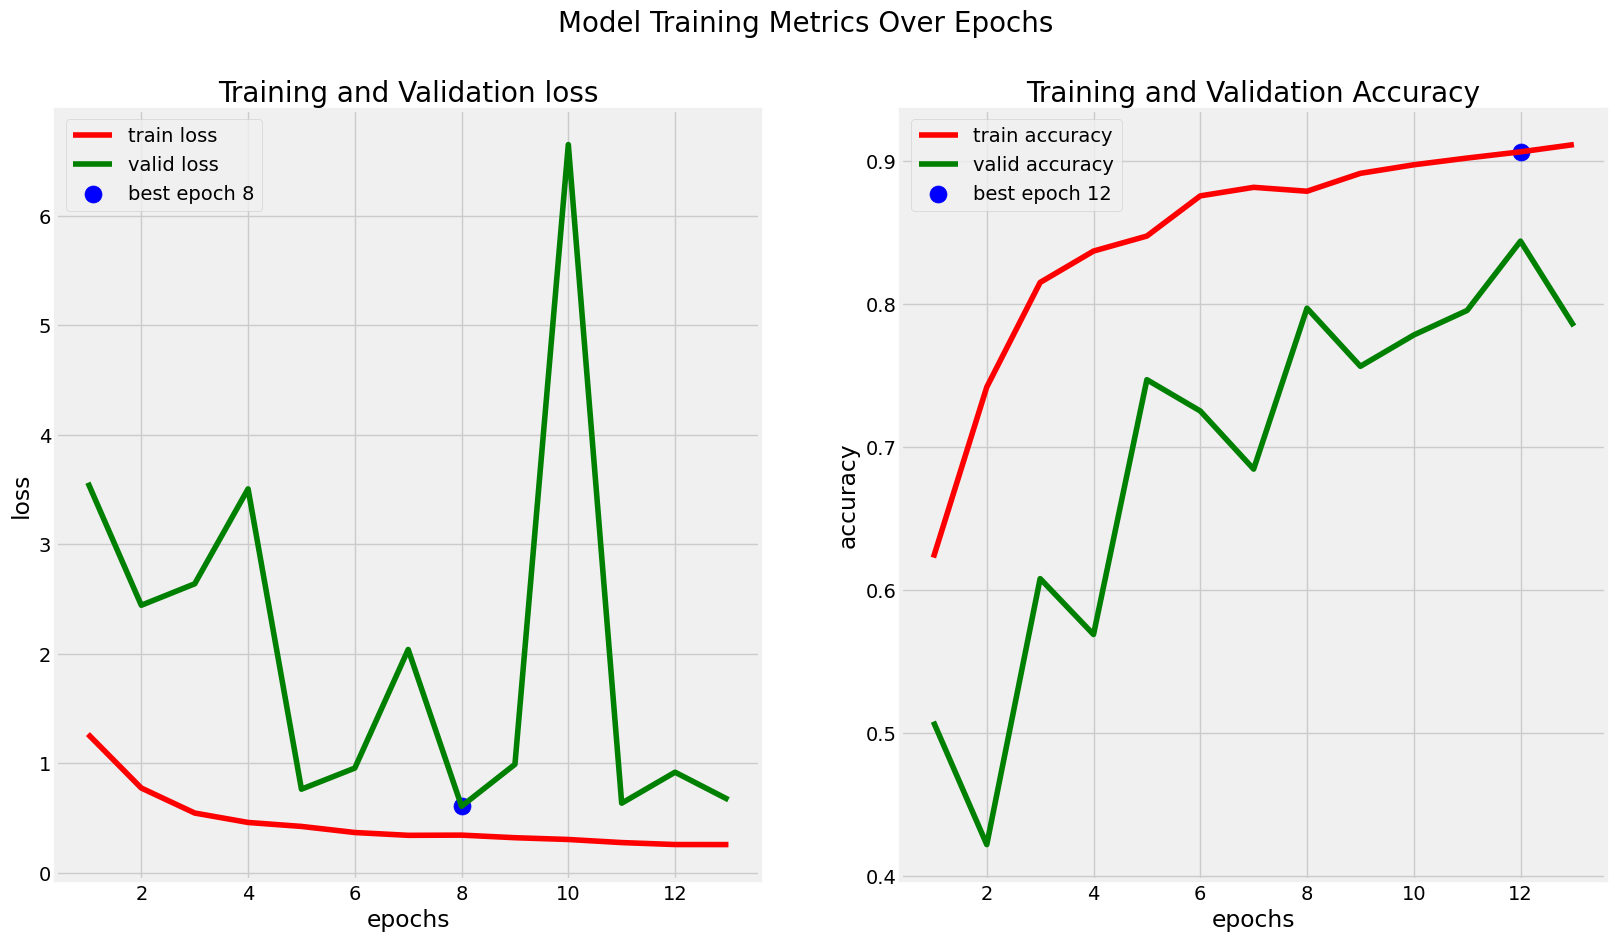

In [12]:
plt.figure(figsize=(20, 8))
tr_loss=history.history["loss"]
val_loss=history.history["val_loss"]
index_loss=np.argmin(val_loss)
loss_lowest=val_loss[index_loss]
l_label=f"best epoch {index_loss+1}"

tr_accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
index_acc=np.argmax(val_accuracy)
acc_highest=tr_accuracy[index_acc]
c_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(tr_accuracy))]


plt.figure(figsize=(20,10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs,tr_loss,"r",label="train loss")
plt.plot(epochs,val_loss,"g",label="valid loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=l_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs,tr_accuracy,"r",label="train accuracy")
plt.plot(epochs,val_accuracy,"g",label="valid accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=c_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Model Training Metrics Over Epochs', fontsize=20);

In [13]:
train_score=resnet_34.evaluate(train_dataset)
valid_score=resnet_34.evaluate(validation_data)
test_score=resnet_34.evaluate(test_dataset)

print(f"Train Loss : {train_score[0]:.3f}")
print(f"Train Accuracy : {train_score[1]*100:.2f}%")
print("-"*20)
print(f"Validation Loss : {valid_score[0]:.3f}")
print(f"Validation Accuracy : {valid_score[1]*100:.2f}%")
print("-"*20)
print(f"Test Loss: {test_score[0]:.3f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

41/41 [==============================] - 6s 75ms/step - loss: 0.6699 - accuracy: 0.7748 - MeanError: 0.1265 - tp: 493.0000 - fp: 135.0000 - tn: 1797.0000 - fn: 151.0000 - precision: 0.7850 - recall: 0.7655 - AUC: 0.9432
Train Loss : 0.531
Train Accuracy : 84.28%
--------------------
Validation Loss : 0.597
Validation Accuracy : 79.37%
--------------------
Test Loss: 0.670
Test Accuracy: 77.48%


In [14]:
import pandas as pd
scores = resnet_34.evaluate(test_dataset, verbose=0)
results = []
epochs=30
result = {
            'Epochs': epochs,
            'Model': 'Resnet',
            'Accuracy': f'{scores[1] * 100:.2f}%',
            'Precision': f'{scores[7] * 100:.2f}%',
            'Recall': f'{scores[8] * 100:.2f}%',
            'AUC': f'{scores[9]:.3f}',

        }
results.append(result)
# Créer le DataFrame Pandas
df = pd.DataFrame(results)
df

,Epochs,Model,Accuracy,Precision,Recall,AUC
0,30,Resnet,77.02%,77.99%,75.93%,0.941


In [ ]:
# Évaluation du modèle sur les données de test
predict = []
label_list = []
for images, labels in test_dataset:
    predict.append(resnet_34(images))
    label_list.append(labels.numpy())

pred = np.concatenate([np.argmax(pred.numpy(), axis=-1).flatten() for pred in predict])
lab = np.concatenate([np.argmax(label, axis=-1).flatten() for label in label_list])

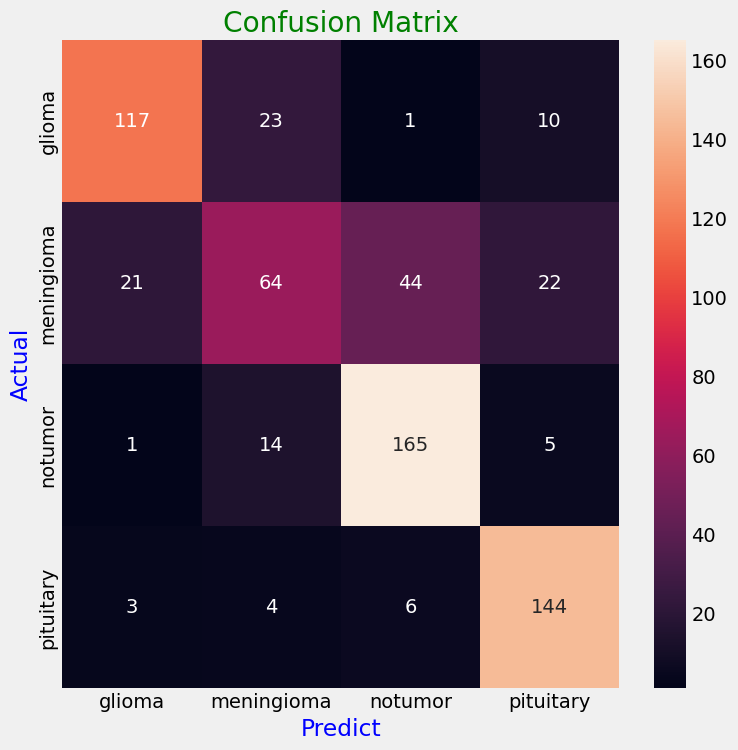

In [ ]:
# Matrice de confusion
cm = confusion_matrix(lab, pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAME, yticklabels=CLASS_NAME)
plt.title('Confusion Matrix', color='green')
plt.ylabel('Actual', color='blue')
plt.xlabel('Predict', color='blue')
plt.show()


1/1 [==============================] - 0s 26ms/step


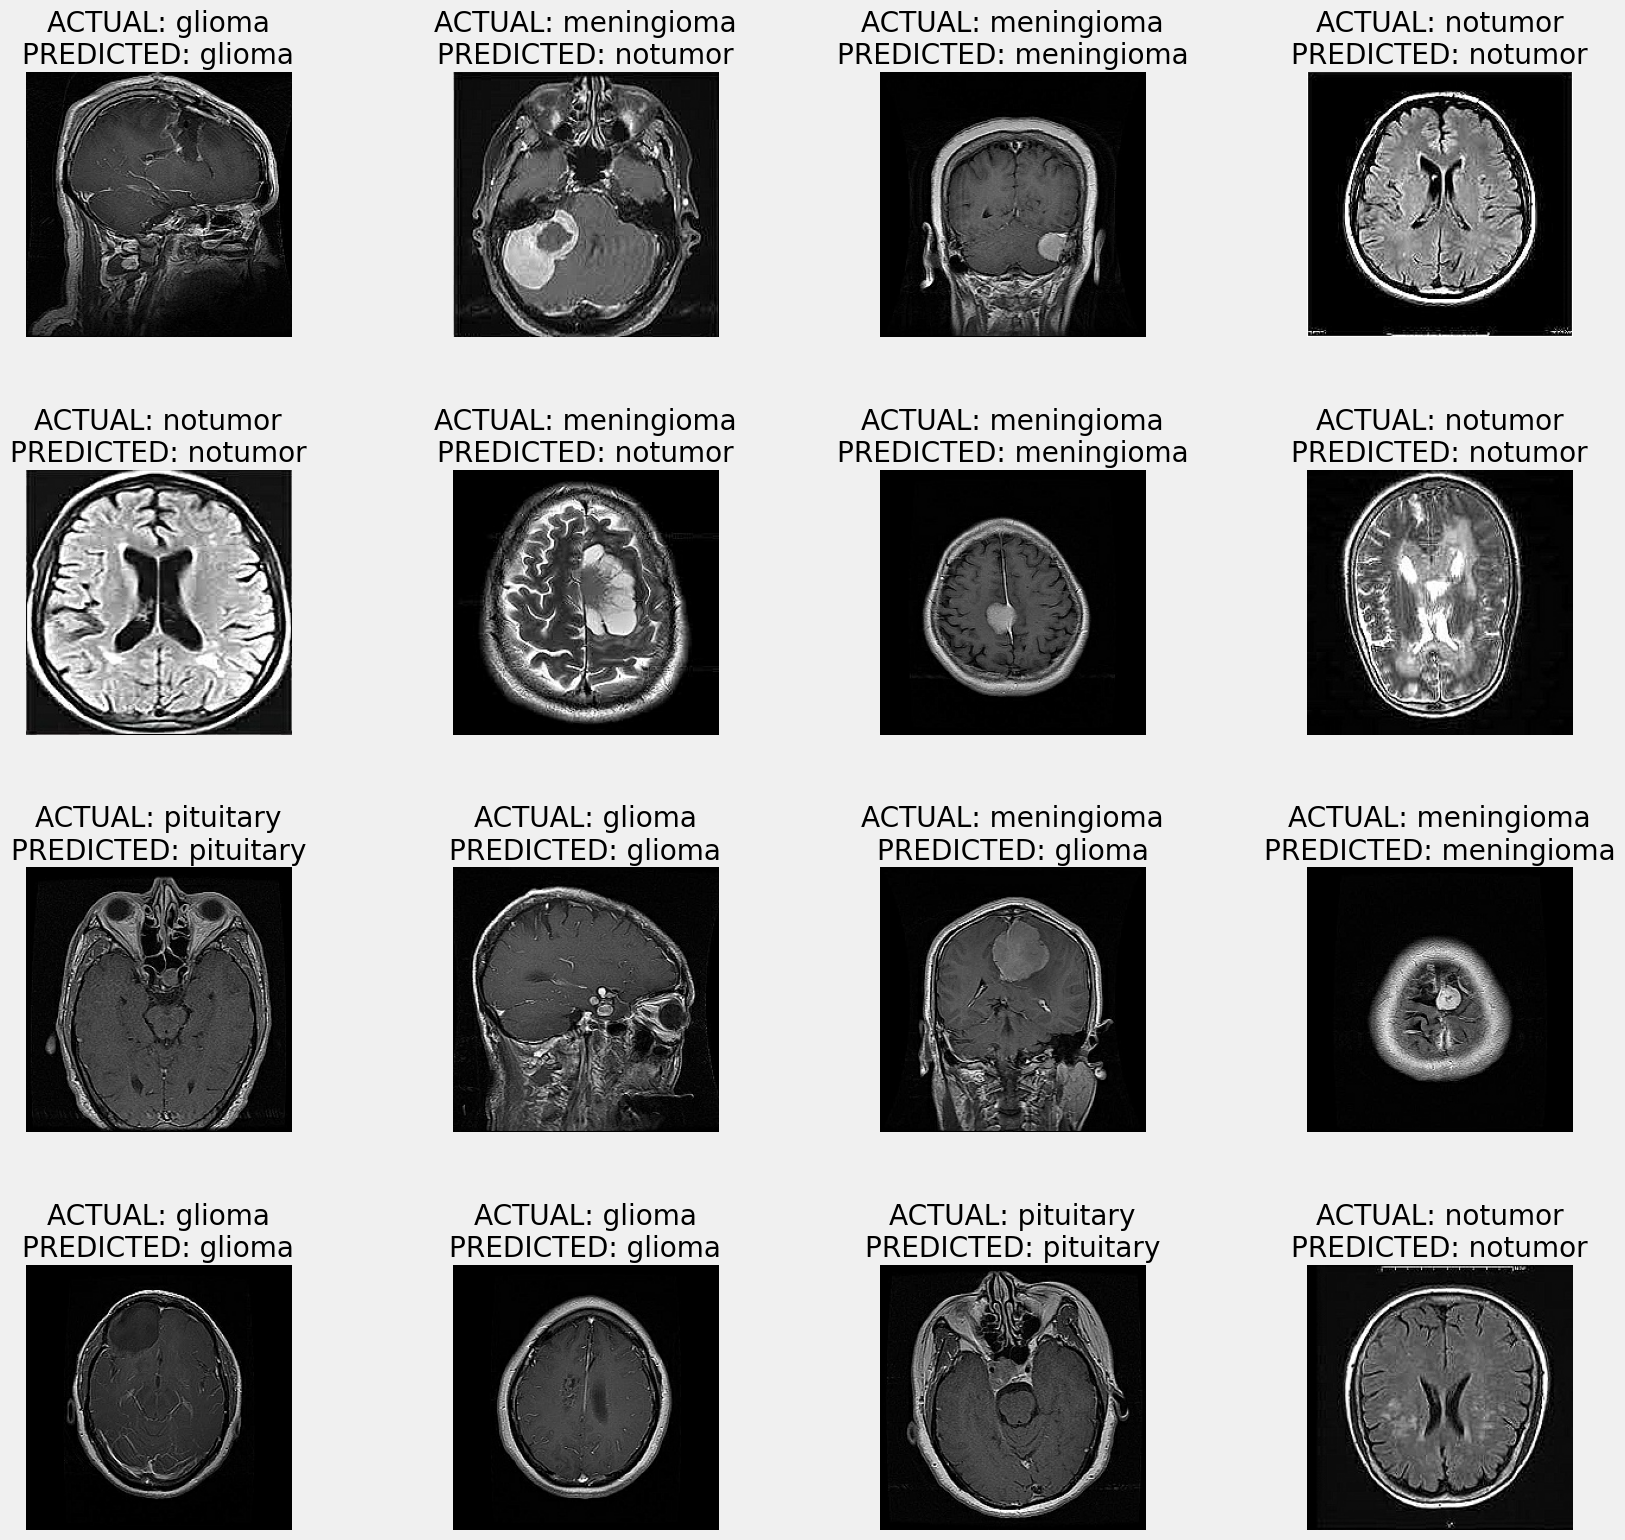

In [ ]:
# Visualisation des prédictions sur un lot de données de test
plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Ajuster les espaces entre les sous-graphiques
for images, labels in test_dataset.take(2):
    predict_batch = resnet_34.predict(images)  # Obtenir les prédictions pour le lot de données
    for i in range(min(len(images), 16)):  # Parcourir les images jusqu'à un maximum de 16
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255.)
        actual_label = CLASS_NAME[np.argmax(labels[i])]
        if i < len(predict_batch):  # Vérifier si l'index est valide dans predict_batch
            predicted_label = CLASS_NAME[np.argmax(predict_batch[i])]
        else:
            predicted_label = "Unknown"
        plt.title(f"ACTUAL: {actual_label}\nPREDICTED: {predicted_label}")
        plt.axis("off")


In [ ]:
preds=resnet_34.predict(test_dataset)
print (preds)
y_pred=np.argmax(preds,axis=1)

41/41 [==============================] - 6s 66ms/step
[[1.4982101e-03 8.0753928e-03 9.7347838e-01 1.6948037e-02]
 [4.9526226e-03 4.0900394e-02 8.3919621e-01 1.1495077e-01]
 [4.9234862e-03 3.2689545e-02 1.4624923e-03 9.6092457e-01]
 ...
 [8.0926830e-01 5.4776296e-02 1.0134103e-03 1.3494201e-01]
 [4.1784942e-01 5.7831782e-01 3.9902647e-05 3.7928540e-03]
 [8.9768356e-01 6.1164789e-02 2.0615249e-03 3.9090168e-02]]


In [ ]:
from sklearn.metrics import  classification_report
CLASS_NAME = ['glioma','meningioma','notumor','pituitary']
y_true = []
for images, labels in test_dataset:
    predict_batch = resnet_34(images)  # Obtenir les prédictions pour le lot de données
    for i in range(len(labels)):  # Parcourir les labels
         y_true.append(np.argmax(labels[i]))
cr=classification_report(y_true,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.22      0.18      0.19       154
           1       0.28      0.21      0.24       150
           2       0.29      0.35      0.32       179
           3       0.23      0.27      0.24       161

    accuracy                           0.25       644
   macro avg       0.25      0.25      0.25       644
weighted avg       0.25      0.25      0.25       644



In [ ]:
#Classification Report
print(classification_report(y_true, y_pred , target_names= CLASS_NAME))

              precision    recall  f1-score   support

      glioma       0.22      0.18      0.19       154
  meningioma       0.28      0.21      0.24       150
     notumor       0.29      0.35      0.32       179
   pituitary       0.23      0.27      0.24       161

    accuracy                           0.25       644
   macro avg       0.25      0.25      0.25       644
weighted avg       0.25      0.25      0.25       644



In [ ]:
# Sauvegarder le modèle en utilisant le format TensorFlow SavedModel
resnet_34.save("/content/drive/My Drive/pfa/Colab Notebooks/Resnet34", save_format='tf', include_optimizer=True)